In [1]:
# load sql extension
%load_ext sql

In [2]:
# connect to database
%sql postgresql://postgres@localhost:5432/hospital_management

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**1. Look for missing values in each table**

In [4]:
%%sql
CREATE OR REPLACE FUNCTION missing_val(tablename TEXT)
RETURNS TABLE(id TEXT) AS $$
DECLARE
    col_list TEXT;
    qry TEXT;
    first_col TEXT;
BEGIN
    -- Get first column name (usually the primary key or id)
    SELECT column_name INTO first_col
    FROM information_schema.columns
    WHERE table_name = tablename
    ORDER BY ordinal_position
    LIMIT 1;

    -- Build a condition: "col1 IS NULL OR col2 IS NULL OR ..."
    SELECT string_agg(format('%I IS NULL', column_name), ' OR ') INTO col_list
    FROM information_schema.columns
    WHERE table_name = tablename;

    -- Build dynamic query
    qry := format('SELECT %I FROM %I WHERE %s', first_col, tablename, col_list);

    -- Execute and return result
    RETURN QUERY EXECUTE qry;
END;
$$ LANGUAGE plpgsql;


 * postgresql://postgres@localhost:5432/hospital_management
Done.


[]

In [5]:
%sql SELECT * FROM missing_val('patients');

 * postgresql://postgres@localhost:5432/hospital_management
0 rows affected.


id


In [6]:
%sql SELECT * FROM missing_val('doctors');

 * postgresql://postgres@localhost:5432/hospital_management
0 rows affected.


id


In [7]:
%sql SELECT * FROM missing_val('appointments');

 * postgresql://postgres@localhost:5432/hospital_management
0 rows affected.


id


In [8]:
%sql SELECT * FROM missing_val('treatments');

 * postgresql://postgres@localhost:5432/hospital_management
0 rows affected.


id


In [9]:
%sql SELECT * FROM missing_val('billing');

 * postgresql://postgres@localhost:5432/hospital_management
0 rows affected.


id


All tables are complete without missing values.

**2. There are 50 records in the `patients`table.**

In [10]:
%sql SELECT count(*) FROM patients;

 * postgresql://postgres@localhost:5432/hospital_management
1 rows affected.


count
50


**3. Extract information of the youngest and oldest patient.**

In [11]:
%%sql
SELECT *
FROM patients
WHERE date_of_birth=(SELECT MIN(date_of_birth) FROM patients) OR date_of_birth=(SELECT MAX(date_of_birth) FROM patients);

 * postgresql://postgres@localhost:5432/hospital_management
2 rows affected.


patient_id,first_name,last_name,gender,date_of_birth,contact_number,address,registration_date,insurance_provider,insurance_number,email
P029,David,Smith,M,2005-05-15,8923607677,789 Pine Rd,2023-04-19,HealthIndia,INS630089,david.smith@mail.com
P034,Alex,Smith,F,1950-01-26,8374657733,321 Maple Dr,2023-06-18,WellnessCorp,INS653880,alex.smith@mail.com


**4. Group patients based on there age and plot the number of patients in each age group.**

In [12]:
%%sql
age_groups <<
WITH age AS (
    SELECT patient_id,
           CASE
               WHEN EXTRACT(YEAR FROM AGE(current_date, date_of_birth)) < 40 THEN 'young'
               WHEN EXTRACT(YEAR FROM AGE(current_date, date_of_birth)) < 60 THEN 'middle-aged'
               ELSE 'old'
           END AS age_group
    FROM patients
)
SELECT COUNT(patient_id) AS num_patients, age_group
FROM age
GROUP BY age_group;



 * postgresql://postgres@localhost:5432/hospital_management
3 rows affected.
Returning data to local variable age_groups


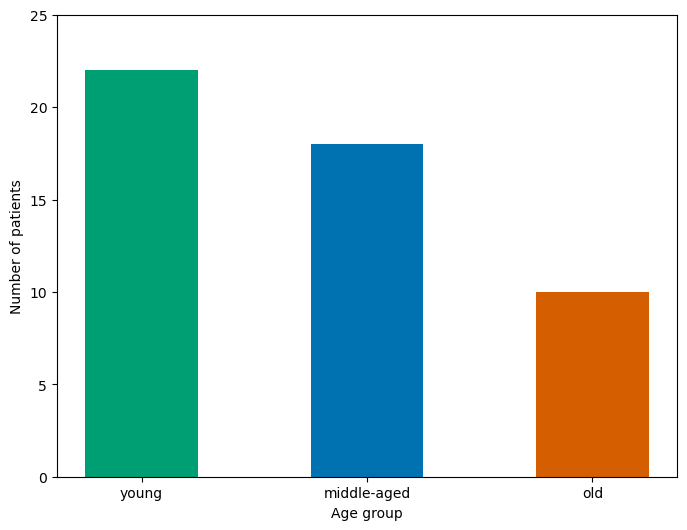

In [13]:
age_groups = pd.DataFrame(age_groups)

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=age_groups['age_group'], height=age_groups['num_patients'], width=0.5, color=['#009e73', '#0072b2', '#d55e00'])
ax.set_ylim(0, 25)
ax.set_ylabel('Number of patients')
ax.set_xlabel('Age group')
plt.show()

**5. Group patients based on gender and plot the distribution.**

In [14]:
%%sql
gender_groups <<
SELECT count(patient_id) AS num_patients, gender
FROM patients
GROUP BY gender;

 * postgresql://postgres@localhost:5432/hospital_management
2 rows affected.
Returning data to local variable gender_groups


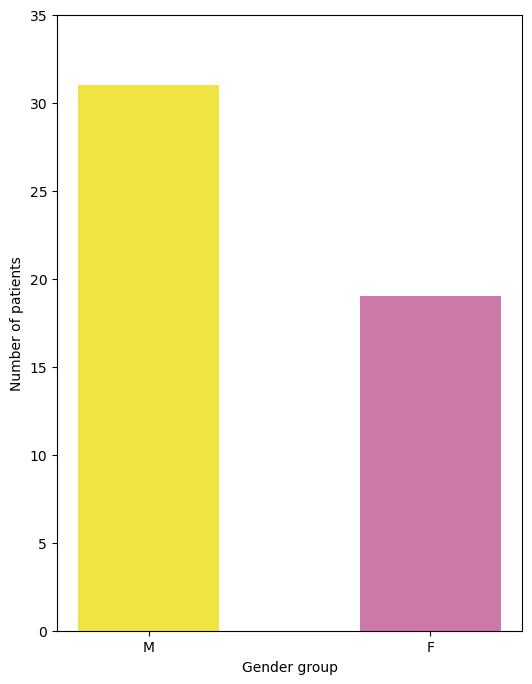

In [15]:
gender_groups = pd.DataFrame(gender_groups)

fig, ax = plt.subplots(figsize=(6,8))
ax.bar(x=gender_groups['gender'], height=gender_groups['num_patients'], width=0.5, color=['#f0e442', '#cc79a7'])
ax.set_ylim(0, 35)
ax.set_ylabel('Number of patients')
ax.set_xlabel('Gender group')
plt.show()

**6. Group patients by the insurance provider they have and plot the data.**

In [16]:
%%sql
insurance_groups <<
SELECT count(*) AS num_patients, insurance_provider
FROM patients 
GROUP BY insurance_provider;

 * postgresql://postgres@localhost:5432/hospital_management
4 rows affected.
Returning data to local variable insurance_groups


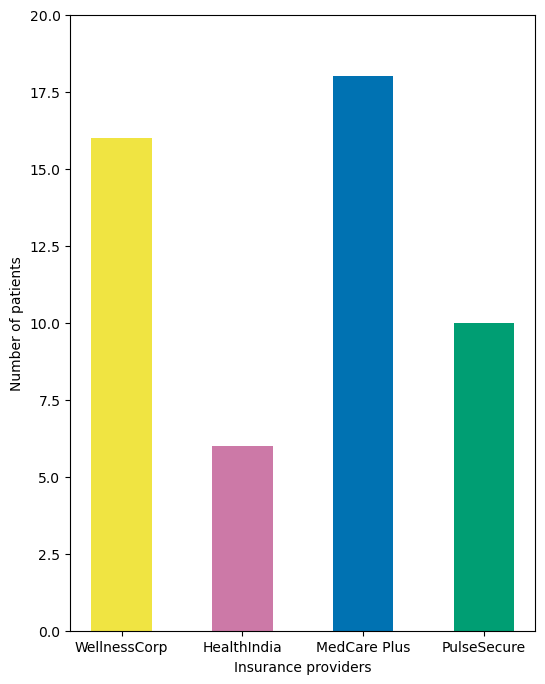

In [17]:
insurance_groups = pd.DataFrame(insurance_groups)

fig, ax = plt.subplots(figsize=(6,8))
ax.bar(x=insurance_groups['insurance_provider'], height=insurance_groups['num_patients'], width=0.5, color=['#f0e442', '#cc79a7', '#0072b2', '#009e73'])
ax.set_ylim(0, 20)
ax.set_ylabel('Number of patients')
ax.set_xlabel('Insurance providers')
plt.show()

**7. Which patient has the most appointments in the system? And what type of appointments does that patient have?**

In [18]:
%%sql 
CREATE VIEW count_appointment AS (
    SELECT patient_id,  COUNT(*) AS num_appointments
    FROM appointments
    GROUP BY patient_id
    ORDER BY num_appointments desc
    LIMIT 1
);

SELECT p.patient_id, p.first_name, p.last_name, p.date_of_birth, p.gender, p.insurance_provider, c.num_appointments
FROM patients p
JOIN (SELECT * FROM count_appointment) c 
ON p.patient_id=c.patient_id;

 * postgresql://postgres@localhost:5432/hospital_management
(psycopg2.errors.DuplicateTable) relation "count_appointment" already exists

[SQL: CREATE VIEW count_appointment AS (
    SELECT patient_id,  COUNT(*) AS num_appointments
    FROM appointments
    GROUP BY patient_id
    ORDER BY num_appointments desc
    LIMIT 1
);]
(Background on this error at: https://sqlalche.me/e/20/f405)


In [19]:
# step 1: get column list
col_list_result = %sql SELECT string_agg('a.' || format('%I', column_name), ', ' ORDER BY ordinal_position) AS cols FROM information_schema.columns WHERE table_name='appointments'
col_list = col_list_result[0].cols  # extract the string

# step 2: use it in another query
query = f"SELECT {col_list} FROM appointments a JOIN (SELECT * FROM count_appointment) c ON a.patient_id=c.patient_id"
%sql {query}




 * postgresql://postgres@localhost:5432/hospital_management
1 rows affected.
 * postgresql://postgres@localhost:5432/hospital_management
10 rows affected.


appointment_id,patient_id,doctor_id,appointment_date,appointment_time,reason_for_visit,status
A014,P012,D010,2023-05-25,10:30:00,Emergency,Cancelled
A028,P012,D006,2023-10-29,15:30:00,Checkup,No-show
A062,P012,D009,2023-06-14,15:15:00,Checkup,No-show
A069,P012,D004,2023-03-29,15:30:00,Therapy,Cancelled
A079,P012,D002,2023-12-26,14:00:00,Follow-up,Cancelled
A122,P012,D008,2023-07-11,14:30:00,Therapy,Cancelled
A140,P012,D005,2023-02-05,15:15:00,Checkup,No-show
A143,P012,D007,2023-09-21,12:15:00,Checkup,Cancelled
A154,P012,D006,2023-03-06,17:30:00,Emergency,No-show
A174,P012,D002,2023-10-31,11:15:00,Follow-up,Cancelled


**8. A function to check the appointments and treatments of a given patient**

In [20]:
%%sql 
DROP FUNCTION IF EXISTS check_patients_info(text);

CREATE OR REPLACE FUNCTION check_patients_info(query_id text)
RETURNS table (
    patient_id text,
    first_name text,
    last_name text,
    insurance_provider text,
    doctor_id text,
    appointment_date date,
    reason_for_visit text,
    status text,
    treatment_type text,
    treatment_date date,
    cost numeric,
    payment_method text,
    payment_status text
) AS $$
BEGIN
    RETURN QUERY
    SELECT p.patient_id, p.first_name, p.last_name, p.insurance_provider, a.doctor_id, a.appointment_date, a.reason_for_visit, a.status, t.treatment_type, t.treatment_date, t.cost, b.payment_method, b.payment_status
    FROM patients p
    RIGHT JOIN appointments a
    ON p.patient_id=a.patient_id
    JOIN treatments t
    ON a.appointment_id=t.appointment_id
    JOIN billing b
    ON t.treatment_id=b.treatment_id
    WHERE p.patient_id=query_id;
END;
$$ LANGUAGE plpgsql;

 * postgresql://postgres@localhost:5432/hospital_management
Done.
Done.


[]

In [21]:
%sql SELECT * FROM check_patients_info('P001')

 * postgresql://postgres@localhost:5432/hospital_management
4 rows affected.


patient_id,first_name,last_name,insurance_provider,doctor_id,appointment_date,reason_for_visit,status,treatment_type,treatment_date,cost,payment_method,payment_status
P001,David,Williams,WellnessCorp,D007,2023-04-09,Consultation,Scheduled,Chemotherapy,2023-04-09,534.03,Cash,Failed
P001,David,Williams,WellnessCorp,D009,2023-01-16,Emergency,Cancelled,Chemotherapy,2023-01-16,3249.41,Credit Card,Failed
P001,David,Williams,WellnessCorp,D006,2023-01-26,Follow-up,Scheduled,ECG,2023-01-26,2960.14,Cash,Paid
P001,David,Williams,WellnessCorp,D005,2023-04-01,Emergency,No-show,Physiotherapy,2023-04-01,975.49,Cash,Pending


**9. What is the averaged/minimal/maximal cost for each type of treatment?**

In [22]:
%%sql
SELECT treatment_type, AVG(cost)::NUMERIC(6,2) AS avg_cost, MIN(cost) AS min_cost, MAX(cost) AS max_cost
FROM treatments
GROUP BY treatment_type
ORDER BY avg_cost DESC;

 * postgresql://postgres@localhost:5432/hospital_management
5 rows affected.


treatment_type,avg_cost,min_cost,max_cost
MRI,3224.95,662.72,4966.18
Physiotherapy,2761.61,956.39,4846.2
X-Ray,2698.87,806.78,4973.63
Chemotherapy,2629.71,534.03,4964.71
ECG,2532.22,582.05,4960.65


**10. Rank the costs of a specific treatment**

In [23]:
%%sql 
DROP FUNCTION IF EXISTS rank_cost_treatment(text);

CREATE OR REPLACE FUNCTION rank_cost_treatment(treatment text)
RETURNS table (
    treatment_type text,
    cost numeric,
    rank bigint
) AS $$
BEGIN
    RETURN QUERY
    SELECT t.treatment_type, t.cost, RANK() OVER(PARTITION BY t.treatment_type ORDER BY t.cost) AS rank
    FROM treatments t
    WHERE t.treatment_type=treatment;
END;
$$ LANGUAGE plpgsql;

 * postgresql://postgres@localhost:5432/hospital_management
Done.
Done.


[]

In [24]:
%sql SELECT * FROM rank_cost_treatment('Physiotherapy');

 * postgresql://postgres@localhost:5432/hospital_management
36 rows affected.


treatment_type,cost,rank
Physiotherapy,956.39,1
Physiotherapy,975.49,2
Physiotherapy,980.95,3
Physiotherapy,1286.77,4
Physiotherapy,1551.7,5
Physiotherapy,1555.89,6
Physiotherapy,1595.67,7
Physiotherapy,1733.72,8
Physiotherapy,1736.63,9
Physiotherapy,1874.86,10


**11. Which insurance company has the highest payment rate?**

In [25]:
%%sql
WITH total_insurance AS (
    SELECT p.insurance_provider, count(p.patient_id) AS total
    FROM patients p
    JOIN billing b 
    ON p.patient_id=b.patient_id
    GROUP BY insurance_provider
),
paid_insurance AS (
    SELECT p.insurance_provider, count(p.patient_id) AS paid
    FROM patients p
    JOIN billing b
    ON p.patient_id=b.patient_id
    WHERE b.payment_method='Insurance'
    GROUP BY p.insurance_provider
)

SELECT t.insurance_provider, ROUND((p.paid::NUMERIC/t.total),3) AS ratio
FROM total_insurance t 
JOIN paid_insurance p 
ON t.insurance_provider=p.insurance_provider
ORDER BY ratio DESC;

 * postgresql://postgres@localhost:5432/hospital_management
4 rows affected.


insurance_provider,ratio
MedCare Plus,0.393
PulseSecure,0.333
WellnessCorp,0.241
HealthIndia,0.227


**12. Which type of treatment is most commonly paid by insurance?**

In [26]:
%%sql
WITH total_treatment AS (
    SELECT t.treatment_type, count(t.treatment_id) AS total
    FROM treatments t
    RIGHT JOIN billing b 
    ON t.treatment_id=b.treatment_id
    GROUP BY t.treatment_type
),
paid_treatment AS (
    SELECT t.treatment_type, count(t.treatment_id) AS paid
    FROM treatments t
    RIGHT JOIN billing b 
    ON t.treatment_id=b.treatment_id
    WHERE b.payment_method='Insurance'
    GROUP BY t.treatment_type
)

SELECT t.treatment_type, ROUND((p.paid::NUMERIC/t.total),3) AS ratio
FROM total_treatment t 
JOIN paid_treatment p 
ON t.treatment_type=p.treatment_type
ORDER BY ratio DESC;


 * postgresql://postgres@localhost:5432/hospital_management
5 rows affected.


treatment_type,ratio
MRI,0.472
X-Ray,0.415
Physiotherapy,0.306
Chemotherapy,0.224
ECG,0.211
